#Customer Segmentation
This project aims to get some insight into the customer behaviour of a UK-based company. Assuming a company that selling some of the products online. The manger wants to know how well does the selling performance by segmenting the customers based on their buying behavior on the market. 
we will take the data from UCI Machine Learning called [Online Retail dataset](https://archive.ics.uci.edu/ml/datasets/online+retail).

The steps are:
* Descibing the dataset
* Cleaning & preparing the dataset
* RFM Table
* Handling the skewed data
* Scaling the data
* K-mean model
* Snake plot
* Discussing the results

# Descibing the Dataset
This dataset is a transactional data that contains transactions from December 1st 2010 until December 9th 2011 for a UK-based online retail. Each row represents the transaction that occurs. It includes the product name, quantity, price, and other columns that represents CustomerID. This dataset is relativly big where it includes over half a million (+500K) rows. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('Online Retail.csv')
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2010 08:26,3.39,17850.0,United Kingdom


In [3]:
df.shape

(541909, 8)

In [4]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

#Cleaning & Preparing the Dataset

In [5]:
cond = df['CustomerID'].notna()
df = df[cond]
df.shape

(406829, 8)

In [6]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [7]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2010 08:26,3.39,17850.0,United Kingdom


In [8]:
df['InvoiceDate'] = pd.to_datetime(df.InvoiceDate, format='%d/%m/%Y %H:%M')

In [9]:
df["InvoiceDate"] = df["InvoiceDate"].dt.date

In [10]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom


In [11]:
# Create TotalSum colummn
df["TotalSum"] = df["Quantity"] * df["UnitPrice"]

In [12]:
# Create date variable that records recency
import datetime
snapshot_date = max(df.InvoiceDate) + datetime.timedelta(days=1)
snapshot_date

datetime.date(2011, 12, 10)

In [13]:
df.shape

(406829, 9)

In [14]:
# Aggregate data by each customer
customers = df.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum',
})
customers.head(5)

,InvoiceDate,InvoiceNo,TotalSum
CustomerID,,,
12346.0,326,2,0.00
12347.0,3,182,4310.00
12348.0,76,31,1797.24
12349.0,19,73,1757.55
12350.0,311,17,334.40


#RFM Table
RFM stands for Recency, Frequency, and Monetary value, each corresponding to some key customer trait. These RFM metrics are important indicators of a customer’s behavior because frequency and monetary value affects a customer’s lifetime value, and recency affects retention, a measure of engagement.

In [15]:
customers.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo':  'Frequency',
    'TotalSum':  'MonetaryValue'
}, inplace = True)
customers.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,2,0.00
12347.0,3,182,4310.00
12348.0,76,31,1797.24
12349.0,19,73,1757.55
12350.0,311,17,334.40


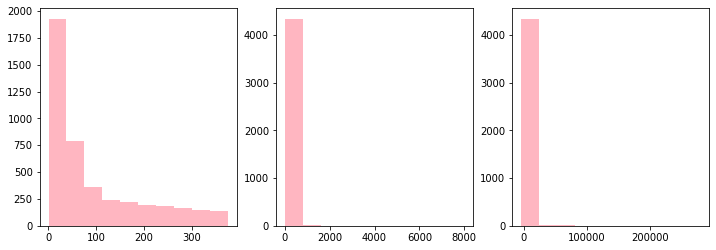

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(12, 4))
ax1.hist(customers['Recency'], color = 'lightpink')
ax2.hist(customers['Frequency'], color = 'lightpink')
ax3.hist(customers['MonetaryValue'], color = 'lightpink')
plt.show()

#Handle the Skewed Data
There are many ways to handle the skewness of the variables.
* Box-Cox Transformation
* Log Transformation


In [17]:
from scipy import stats
customers_fix = pd.DataFrame()
customers_fix["Recency"] = stats.boxcox(customers['Recency'])[0]
customers_fix["Frequency"] = stats.boxcox(customers['Frequency'])[0]
customers_fix["MonetaryValue"] = pd.Series(np.cbrt(customers['MonetaryValue'])).values
customers_fix.tail()

,Recency,Frequency,MonetaryValue
4367,8.932980,2.460908,5.652483
4368,7.949051,2.058202,4.323541
4369,2.449000,2.762414,5.610440
4370,1.544575,8.057611,12.795376
4371,5.087438,4.808490,12.247810


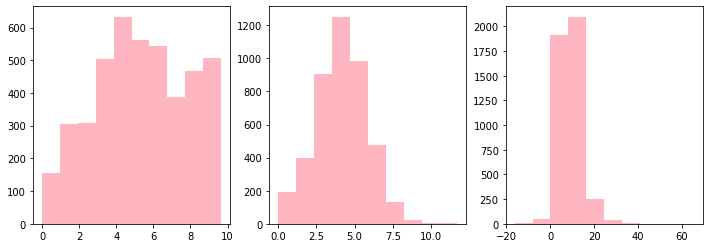

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(12, 4))
ax1.hist(customers_fix['Recency'], color = 'lightpink')
ax2.hist(customers_fix['Frequency'], color = 'lightpink')
ax3.hist(customers_fix['MonetaryValue'], color = 'lightpink')
plt.show()

#Scaling the Data

In [19]:
scaler = StandardScaler()
scaler.fit(customers_fix)
customers_normalized = scaler.transform(customers_fix)

In [20]:
# Assert that it has mean 0 and variance 1
print(customers_normalized.mean(axis = 0).round(2)) 
print(customers_normalized.std(axis = 0).round(2)) 

[-0.  0. -0.]
[1. 1. 1.]


# K-means Model

In [21]:
from sklearn.cluster import KMeans

In [22]:
SSE = {}
for k in range(1,11):
  kmeans = KMeans(n_clusters = k, random_state=42)
  kmeans.fit(customers_normalized)
  SSE[k] = kmeans.inertia_ 

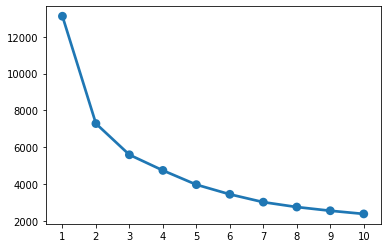

In [23]:
sns.pointplot(x=list(SSE.keys()), y=list(SSE.values()))

In [24]:
model = KMeans(n_clusters= 3, random_state=42)
model.fit(customers_normalized)
model.labels_.shape

(4372,)

In [25]:
model.labels_

array([0, 2, 1, ..., 1, 2, 1], dtype=int32)

In [26]:
customers['Cluster'] = model.labels_
customers.head()

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12346.0,326,2,0.00,0
12347.0,3,182,4310.00,2
12348.0,76,31,1797.24,1
12349.0,19,73,1757.55,1
12350.0,311,17,334.40,0


In [27]:
customers.groupby(['Cluster']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
})

Recency   Frequency MonetaryValue      
               mean        mean          mean count
Cluster                                            
0        185.280892   19.218204    352.110477  1659
1         42.911065   67.518097   1008.262680  1934
2         18.477535  313.691913   7401.713107   779

#Snake Plot

In [28]:
# Create the dataframe
df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = customers.index
df_normalized['Cluster'] = model.labels_
# Melt The Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','MonetaryValue'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()

,ID,Cluster,Attribute,Value
0,12346.0,0,Recency,1.606608
1,12347.0,2,Recency,-1.696240
2,12348.0,1,Recency,0.317615
3,12349.0,1,Recency,-0.669146
4,12350.0,0,Recency,1.560253


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


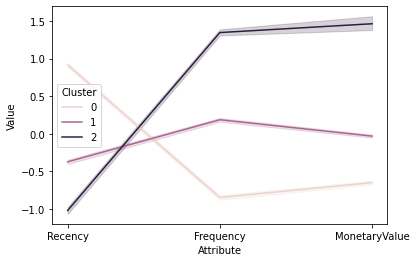

In [29]:
# Visualize it
sns.lineplot('Attribute', 'Value', hue='Cluster', data=df_nor_melt)

#Discuss the Results
We infer that:
 
*  **New Customer**: Cluster 0 is less frequent, less to spend, but they buy the product recently. Therefore, it could be the cluster of new customer.
*   **Churned Customers**: Cluster 1 is less frequent, less to spend, and they buy the product at the old time. Therefore, it could be the cluster of churned customers.
*  **Loyal Customer**: Cluster 2 is frequent, spend more, and they buy the product recently. Therefore, it could be the cluster of a loyal customer.







#Refernces:
* [RFM Model-Based Customer Segmentation](https://link.springer.com/article/10.1057/dbm.2012.17)  
* [Elbow Method](https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/)
*   [Handling Skewed Data](https://towardsdatascience.com/top-3-methods-for-handling-skewed-data-1334e0debf45)

